Convolutional Neural Network by Marlo Esperson


Raytheon Advisors: David Detienne and Kerry Courtright

Faculty Advisor: Alex Orange

Team Members: Josh Miraglia, Ryan Procarione, and Erik Graham

Last Update: 2.02.2022 

The purpose of this program is to take in labeled generated signal data (bandwidth, center frequency, and signal-to-noise ratio (SNR)) from a Massive MIMO antenna and use it to train and test a convolutional neural network model that will be able to estimate bandwidth, center frequency, time, and SNR parameters.


Read in all signal data and labels:

In [1]:
#plotting function
%matplotlib notebook

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

#spec = 2048

#M = 9999 # number of signals

filein = "/local/2048_Angles_First.h5"
#filein = "/mnt/nndataset/SOUNDER_storepath/Anechoic_Data.h5"

with h5py.File(filein, "r") as f:
    folders = f.keys()
    #print("Folders in base: ", folders)
 

    #L = f.get('labels') #Retrieves the "labels" folder.
    #S = f.get('signals') #Retrieves "signals" folder.
    #print(f('dataset').keys())
    
    #Access generated data:
    data = f.get('generated_data')
    print(data.keys())
    #signal_data = data.get('dataset')
    signal_data = data.get('signal_0')
    gen_sigs = np.array(signal_data)
    print(data.keys())

    
    #data = np.array(S.get('rx_signals'))
    #dataset = data[0,0,:,:] #Sets the last two dimensions of the 4 dimensional array as the main 
                            #dataset
   

    #print(L.keys())
    #print(dataset.shape)
    #bandwidth = np.array(L.get('bandwidth'))
    #centers = np.array(L.get('center_freq')) #TODO: include frequency in name
    #SNR = np.array(L.get('SNR'))
    
    bandwidth = np.array(data.get('bandwidths'))
    centerf = np.array(data.get('centers'))
    start = np.array(data.get('starts'))
    stop = np.array(data.get('stops'))
    
    print(signal_data)

<KeysViewHDF5 ['angles', 'bandwidths', 'centers', 'mods', 'signal_0', 'signal_1', 'starts', 'stops']>
<KeysViewHDF5 ['angles', 'bandwidths', 'centers', 'mods', 'signal_0', 'signal_1', 'starts', 'stops']>
<HDF5 dataset "signal_0": shape (30000, 2048), type "<c16">


# Move bandwidth labeled data into an array:

<IPython.core.display.Javascript object>


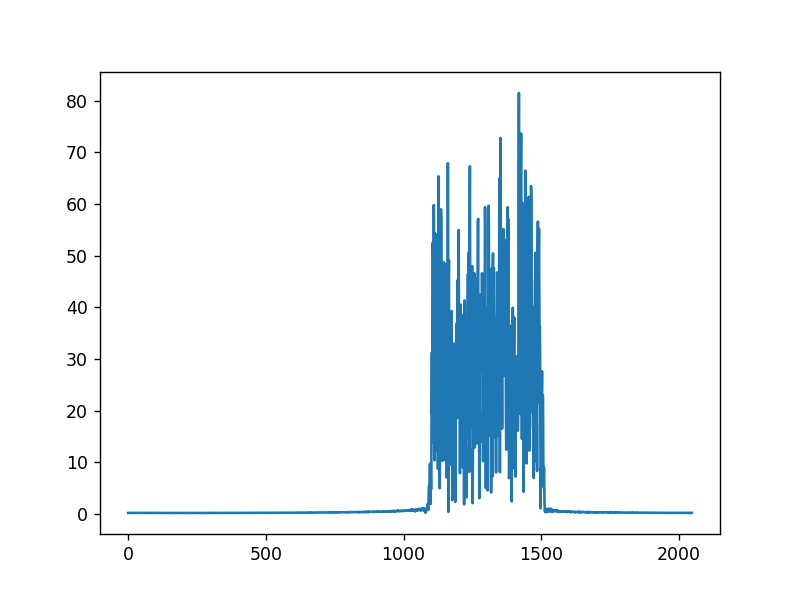

In [3]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(gen_sigs), (1,))) #Pass this into NN.
plt.plot(abs(dataset_fft[20]))
plt.show()
#dataset_fft = abs(gen_sigs) #Pass this into NN.

Move center frequency labeled data into array:

Splitting Dataset into Training and Testing Data

In [4]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf

#config = tf.ConfigProto(intra_op_parallelism_threads=24,
#                        inter_op_parallelism_threads=2,
#                        allow_soft_placement=True,
#                        device_count = {'CPU': 24})
#session = tf.Session(config=config)
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

#from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime

#Casts a list indexing from 0 to 9999 for each labeled dataset
#Bandwidth
#print(len(bandwidth))
# idx_bw = list(range(len(bandwidth)))
idx_cf = list(range(len(centerf)))
idx_start = list(range(len(start)))
idx_stop = list(range(len(stop)))

#Center Frequency
#idx_cf = list(range(len(centers)))
#Signal-to-Noise Ratio
#idx_SNR = list(range(len(SNR)))



#Shuffles indices of bandwidth, center freq, and SNR datasets
# random.shuffle(idx_bw)


# Ramdom seed 3700 is shuffling data correctly (omitted seed (5) due to it not shuffling)
random.Random(3700).shuffle(idx_cf)
random.Random(3700).shuffle(idx_start)
random.Random(3700).shuffle(idx_stop)
#random.shuffle(idx_SNR)

#Splitting datasets (8000 assigned to training and 2000 to testing)
# training_indices_bw, testing_indices_bw = np.split(idx_bw, [int(0.8*len(idx_bw))])
training_indices_cf, testing_indices_cf = np.split(idx_cf, [int(0.8*len(idx_cf))])
training_indices_start, testing_indices_start = np.split(idx_start, [int(0.8*len(idx_start))])
training_indices_stop, testing_indices_stop = np.split(idx_stop, [int(0.8*len(idx_stop))])

#training_indices_SNR, testing_indices_SNR = np.split(idx_SNR, [int(0.8*len(idx_SNR))])

#initializing testing and training data and label arrays
# training_data_bw = []
# training_labels_bw = []
# testing_data_bw = []
# testing_labels_bw = []

training_data_cf = []
training_labels_cf = []
testing_data_cf = []
testing_labels_cf = []

training_data_start = []
training_labels_start = []
testing_data_start = []
testing_labels_start = []

training_data_stop = []
training_labels_stop = []
testing_data_stop = []
testing_labels_stop = []

# training_data_SNR = []
# training_labels_SNR = []

# testing_data_SNR = []
# testing_labels_SNR = []


#fill up training dataset and the associated bandwidths (splitting here)
# for idx_bw in training_indices_bw:
#     #iterate through all indices and print
#     training_data_bw.append(dataset_fft[idx_bw])
#     training_labels_bw.append(bandwidth[idx_bw])
#     #print(idx)

#     #put bandwidth training_data and training_labels into a numpy array.
# training_data_bw = tf.convert_to_tensor(np.array(training_data_bw), dtype=tf.float32)
# training_labels_bw = tf.convert_to_tensor(np.array(training_labels_bw), dtype=tf.float32)
# #training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
# for idx_bw in testing_indices_bw:
#     testing_data_bw.append(dataset_fft[idx_bw])
#     testing_labels_bw.append(bandwidth[idx_bw])


# testing_data_bw = tf.convert_to_tensor(np.array(testing_data_bw), dtype=tf.float32)
# testing_labels_bw = tf.convert_to_tensor(np.array(testing_labels_bw), dtype=tf.float32)
# #testing_labels_bw = tf.reshape(testing_labels_bw, testing_labels_bw.get_shape()+(1,))


# for idx_cf in training_indices_cf:
#     #iterate through all indices and print
#     training_data_cf.append(dataset_fft[idx_cf])
#     training_labels_cf.append(centerf[idx_cf])
#     #print(idx)

#     #put bandwidth training_data and training_labels into a numpy array.
# training_data_cf = tf.convert_to_tensor(np.array(training_data_cf), dtype=tf.float32)
# training_labels_cf = tf.convert_to_tensor(np.array(training_labels_cf), dtype=tf.float32)
# #training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
# for idx_cf in testing_indices_cf:
#     testing_data_cf.append(dataset_fft[idx_cf])
#     testing_labels_cf.append(centerf[idx_cf])

# testing_data_cf = tf.convert_to_tensor(np.array(testing_data_cf), dtype=tf.float32)
# testing_labels_cf = tf.convert_to_tensor(np.array(testing_labels_cf), dtype=tf.float32)



for idx_start in training_indices_start:
    #iterate through all indices and print
    training_data_start.append(dataset_fft[idx_start])
    training_labels_start.append(start[idx_start])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data_start = tf.convert_to_tensor(np.array(training_data_start), dtype=tf.float32)
training_labels_start = tf.convert_to_tensor(np.array(training_labels_start), dtype=tf.float32)
#training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
for idx_start in testing_indices_start:
    testing_data_start.append(dataset_fft[idx_start])
    testing_labels_start.append(start[idx_start])

testing_data_start = tf.convert_to_tensor(np.array(testing_data_start), dtype=tf.float32)
testing_labels_start = tf.convert_to_tensor(np.array(testing_labels_start), dtype=tf.float32)





for idx_stop in training_indices_stop:
    #iterate through all indices and print
    training_data_stop.append(dataset_fft[idx_stop])
    training_labels_stop.append(stop[idx_stop])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data_stop = tf.convert_to_tensor(np.array(training_data_stop), dtype=tf.float32)
training_labels_stop = tf.convert_to_tensor(np.array(training_labels_stop), dtype=tf.float32)
#training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
for idx_stop in testing_indices_stop:
    testing_data_stop.append(dataset_fft[idx_stop])
    testing_labels_stop.append(stop[idx_stop])

testing_data_stop = tf.convert_to_tensor(np.array(testing_data_stop), dtype=tf.float32)
testing_labels_stop = tf.convert_to_tensor(np.array(testing_labels_stop), dtype=tf.float32)


#fill up training dataset and the associated center frequency (splitting here)
for idx_cf in training_indices_cf:
    #iterate through all indices and print
    training_data_cf.append(dataset_fft[idx_cf])
    training_labels_cf.append(centerf[idx_cf])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data_cf = tf.convert_to_tensor(np.array(training_data_cf), dtype=tf.float32)
training_labels_cf = tf.convert_to_tensor(np.array(training_labels_cf), dtype=tf.float32)
   
for idx_cf in testing_indices_cf:
    testing_data_cf.append(dataset_fft[idx_cf])
    testing_labels_cf.append(centerf[idx_cf])


testing_data_cf = tf.convert_to_tensor(np.array(testing_data_cf), dtype=tf.float32)
testing_labels_cf = tf.convert_to_tensor(np.array(testing_labels_cf), dtype=tf.float32)


# for idx_SNR in training_indices_SNR:
#     #iterate through all indices and print
#     training_data_SNR.append(dataset[idx_SNR])
#     training_labels_SNR.append(SNR[idx_SNR])
#     #print(idx)

#     #put bandwidth training_data and training_labels into a numpy array.
# training_data_SNR = np.array(training_data_SNR)
# training_labels_SNR = np.array(training_labels_SNR)
   
# for idx_SNR in testing_indices_SNR:
#     testing_data_SNR.append(dataset[idx_SNR])
#     testing_labels_SNR.append(SNR[idx_SNR])


# testing_data_SNR = np.array(testing_data_SNR)
# testing_labels_SNR = np.array(testing_labels_SNR)

Network Structure (Topology)

In [ ]:


# input = tf.keras.layers.Input(shape = (2048, 1)) #2 dimensions
# #Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
# #length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
# layer1 = Conv1D(12, 300, activation='relu')(input)  
# layer2 = MaxPooling1D(pool_size = (2))(layer1) #Look into different kind of pooling layers.
# #Layer that will look for features that will take 2048 points and narrow down and find the index
# #around the maximum points and around the maximum.
# #TODO: Email Johnathan and ask about pool size recommendations. Also any recommendations beyond a MaxPooling layer.
# layer3 = Flatten()(layer2) #10240 outputs
# layer4 = Dense(10000)(layer3)
# layer5 = Dense(1000)(layer4) 
# layer6 = Dense(64)(layer5)
# layer7 = Dense(1)(layer6) #output layer

# model = tf.keras.models.Model(inputs = input, outputs = layer7)
# model.summary()

# #TODO: Experiment with learning rate
# model.compile(optimizer = "adam", #Johnathan Wintrode
#              loss='mean_squared_error')
# #accuracy = Number of correct predictions / total number of predictions made

In [ ]:
# from tensorflow import keras

# input = tf.keras.layers.Input(shape = (2048, 1)) #2 dimensions
# #Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
# #length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
# #Conv1D(How many kernels, points that define the kernels, activation....)

# layer1 = Conv1D(12, 24, activation='relu')(input)  
# layer2 = MaxPooling1D(pool_size = (2))(layer1) #Look into different kind of pooling layers.
# #Layer that will look for features that will take 2048 points and narrow down and find the index
# #around the maximum points and around the maximum.
# #TODO: Email Johnathan and ask about pool size recommendations. Also any recommendations beyond a MaxPooling layer.

# # layer3 = Conv1D(12, 300, activation='relu')(layer2)
# # layer3 = MaxPooling1D(2)(layer3)

# # layer4 = Conv1D(12, 300, activation='relu')(layer3)
# # layer4 = MaxPooling1D(2)(layer4)

# layer3 = Flatten()(layer2) #10240 outputs

# #Rule of thumb: twice the input (2048*2)
# layer4 = Dense(4096)(layer3)

# layer5 = Dense(1000)(layer4)

# layer6 = Dense(64)(layer5)

# layer7 = Dense(1)(layer6) #output layer

# model = tf.keras.models.Model(inputs = input, outputs = layer7)
# model.summary()

# opt = keras.optimizers.Adam(learning_rate = 0.00000001)

# #opt = keras.optimizers.SGD(learning_rate = 0.0001)

# #Johnathan Wintrode
# model.compile(loss='mean_squared_error', optimizer = opt)


In [5]:
from tensorflow import keras

finput = tf.keras.layers.Input(shape = (2048, 1), name = "finput") #2 dimensions
##Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
##length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
##Conv1D(How many kernels, points that define the kernels, activation....)

flayer1 = Conv1D(filters=64, kernel_size = 3, activation="relu", name = "flayer1")(input)
flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1)

flayer2 = Conv1D(filters=128, kernel_size = 3, activation = "relu", name = "flayer2")(flayer1)
flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

flayer3 = Conv1D(filters = 128, kernel_size = 3, activation = "relu", name = "flayer3")(flayer2)
flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)

flayer4 = Conv1D(filters = 256, kernel_size = 3, activation  ="relu", name = "flayer4")(flayer3)
flayer4 = MaxPooling1D(2, name = "fPool4")(flayer4)

flayer5 = Conv1D(filters = 512, kernel_size = 3, activation = "relu", name = "flayer5")(flayer4)
flayer5 = MaxPooling1D(3, name = "fPool5")(flayer5)

flayer6 = Flatten(name = "fFlatten")(flayer5)

flayer7 = Dense(64, activation = "relu", name = "fDense1")(flayer6)

foutput = Dense(1, activation = "relu", name = "fDense2")(flayer7)


#layer1 = Conv1D(12, 24, activation='relu')(input)  
#layer2 = MaxPooling1D(pool_size = (2))(layer1) #Look into different kind of pooling layers.
##Layer that will look for features that will take 2048 points and narrow down and find the index
##around the maximum points and around the maximum.
##TODO: Email Johnathan and ask about pool size recommendations. Also any recommendations beyond a MaxPooling layer.

## layer3 = Conv1D(12, 300, activation='relu')(layer2)
## layer3 = MaxPooling1D(2)(layer3)

## layer4 = Conv1D(12, 300, activation='relu')(layer3)
## layer4 = MaxPooling1D(2)(layer4)

#layer3 = Flatten()(layer2) #10240 outputs

# Rule of thumb: twice the input (2048*2)
#layer4 = Dense(4096)(layer3)

#layer5 = Dense(1000)(layer4)

#layer6 = Dense(64)(layer5)

#layer7 = Dense(1)(layer6) #output layer

model = tf.keras.models.Model(inputs = input, outputs = foutput)
model.summary()

#opt = keras.optimizers.Adam(learning_rate = 0.00000001)

opt = keras.optimizers.Adam(learning_rate = 0.0000001)

#Johnathan Wintrode
model.compile(loss='mean_squared_error', optimizer = opt)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2046, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1023, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1021, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 510, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 508, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 254, 128)          0     

Training the Network

In [ ]:
print(training_data_cf)

In [6]:
# training_data_bw = tf.data.Dataset.from_tensor_slices(training_data_bw)
# training_labels_bw = tf.data.Dataset.from_tensor_slices(training_labels_bw)
# testing_data_bw = tf.data.Dataset.from_tensor_slices(testing_data_bw)
# testing_labels_bw = tf.data.Dataset.from_tensor_slices(testing_labels_bw)

training_data_cf = tf.data.Dataset.from_tensor_slices(training_data_cf)
training_labels_cf = tf.data.Dataset.from_tensor_slices(training_labels_cf)
testing_data_cf = tf.data.Dataset.from_tensor_slices(testing_data_cf)
testing_labels_cf = tf.data.Dataset.from_tensor_slices(testing_labels_cf)

training_data_start = tf.data.Dataset.from_tensor_slices(training_data_start)
training_labels_start = tf.data.Dataset.from_tensor_slices(training_labels_start)
testing_data_start = tf.data.Dataset.from_tensor_slices(testing_data_start)
testing_labels_start = tf.data.Dataset.from_tensor_slices(testing_labels_start)

training_data_stop = tf.data.Dataset.from_tensor_slices(training_data_stop)
training_labels_stop = tf.data.Dataset.from_tensor_slices(training_labels_stop)
testing_data_stop = tf.data.Dataset.from_tensor_slices(testing_data_stop)
testing_labels_stop = tf.data.Dataset.from_tensor_slices(testing_labels_stop)

In [7]:
# training_data_bw, training_labels_bw
training_data_cf, training_labels_cf
training_data_start, training_labels_start
training_data_stop, training_labels_stop

(<TensorSliceDataset shapes: (2048,), types: tf.float32>,
 <TensorSliceDataset shapes: (), types: tf.float32>)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Question: Can I add more than just training_data_bw and training_labels_bw in the parameters below ????????
# training_data = tf.data.Dataset.zip((training_data_bw, training_labels_bw))
# print(training_data)
# training_data = training_data.batch(128)
# print(training_data)
# training_data = training_data.cache()
# print(training_data)
# training_data = training_data.prefetch(tf.data.AUTOTUNE)
# print(training_data)


# testing_data = tf.data.Dataset.zip((testing_data_bw, testing_labels_bw))
# testing_data = testing_data.batch(128)
# testing_data = testing_data.cache()
# testing_data = testing_data.prefetch(tf.data.AUTOTUNE)

# training_data

In [8]:
training_data_cf = tf.data.Dataset.zip((training_data_cf, training_labels_cf))
print(training_data_cf)
training_data_cf = training_data_cf.batch(128)
print(training_data_cf)
training_data_cf = training_data_cf.cache()
print(training_data_cf)
training_data_cf = training_data_cf.prefetch(tf.data.AUTOTUNE)
print(training_data_cf)


testing_data_cf = tf.data.Dataset.zip((testing_data_cf, testing_labels_cf))
testing_data_cf = testing_data_cf.batch(128)
testing_data_cf = testing_data_cf.cache()
testing_data_cf = testing_data_cf.prefetch(tf.data.AUTOTUNE)

training_data_cf

<ZipDataset shapes: ((2048,), ()), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>
<CacheDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>


<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>

In [ ]:
# training_data_start = tf.data.Dataset.zip((training_data_start, training_labels_start))
# print(training_data_start)
# training_data_start = training_data_start.batch(128)
# print(training_data_start)
# training_data_start = training_data_start.cache()
# print(training_data_start)
# training_data_start = training_data_start.prefetch(tf.data.AUTOTUNE)
# print(training_data_start)


# testing_data_start = tf.data.Dataset.zip((testing_data_start, testing_labels_start))
# testing_data_start = testing_data_start.batch(128)
# testing_data_start = testing_data_start.cache()
# testing_data_start = testing_data_start.prefetch(tf.data.AUTOTUNE)

# training_data_start

In [ ]:
# training_data_stop = tf.data.Dataset.zip((training_data_stop, training_labels_stop))
# print(training_data_stop)
# training_data_stop = training_data_stop.batch(128)
# print(training_data_stop)
# training_data_stop = training_data_stop.cache()
# print(training_data_stop)
# training_data_stop = training_data_stop.prefetch(tf.data.AUTOTUNE)
# print(training_data_stop)


# testing_data_stop = tf.data.Dataset.zip((testing_data_stop, testing_labels_stop))
# testing_data_stop = testing_data_stop.batch(128)
# testing_data_stop = testing_data_stop.cache()
# testing_data_stop = testing_data_stop.prefetch(tf.data.AUTOTUNE)

# training_data_stop

In [ ]:
#training, default batch size is 1/32 of the dataset
#TODO: increase epochs later to see differences in loss and val_loss
#history = model.fit(training_data, training_labels, epochs = 10, validation_data = (testing_data, testing_labels), callbacks=[tensorboard_callback])
#I like the results for 1500 epochs (1/10/2021)
#history = model.fit(training_data, epochs=3000, validation_data=testing_data)

#How many epochs to perform?



In [9]:
history_cf = model.fit(training_data_cf, epochs=1500, validation_data=testing_data_cf)

Epoch 1/1500
188/188 [==============================] - 35s 180ms/step - loss: 0.0129 - val_loss: 0.0049
Epoch 2/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/1500
188/188 [==============================] - 32s 171ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/1500
188/188 [==============================] 

Epoch 155/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 156/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 157/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 158/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 159/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 160/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 161/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 162/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 163/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 164/1500
188/188 [=============

188/188 [==============================] - 31s 166ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 308/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 309/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 310/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 311/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 312/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 313/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 314/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 315/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 316/1500
188/188 [============================

188/188 [==============================] - 32s 171ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 460/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 461/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 462/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 463/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 464/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 465/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 466/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 467/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 468/1500
188/188 [============================

188/188 [==============================] - 31s 165ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 612/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 613/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 614/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 615/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 616/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 617/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 618/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 619/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 620/1500
188/188 [============================

188/188 [==============================] - 32s 168ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 764/1500
188/188 [==============================] - 32s 171ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 765/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 766/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 767/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 768/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 769/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 770/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 771/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 772/1500
188/188 [============================

188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 916/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 917/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 918/1500
188/188 [==============================] - 32s 171ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 919/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 920/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 921/1500
188/188 [==============================] - 32s 172ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 922/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 923/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 924/1500
188/188 [============================

188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1068/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1069/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1070/1500
188/188 [==============================] - 31s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1071/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1072/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1073/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1074/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1075/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1076/1500
188/188 [===================

188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1144/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1145/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1146/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1147/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1148/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1149/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1150/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1151/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1152/1500
188/188 [===================

188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1220/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1221/1500
188/188 [==============================] - 31s 164ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1222/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1223/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1224/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1225/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1226/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1227/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1228/1500
188/188 [===================

188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1296/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1297/1500
188/188 [==============================] - 31s 163ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1298/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1299/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1300/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1301/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1302/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1303/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1304/1500
188/188 [===================

188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1372/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1373/1500
188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1374/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1375/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1376/1500
188/188 [==============================] - 32s 170ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1377/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1378/1500
188/188 [==============================] - 32s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1379/1500
188/188 [==============================] - 32s 169ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1380/1500
188/188 [===================

188/188 [==============================] - 31s 165ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1448/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1449/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1450/1500
188/188 [==============================] - 31s 163ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1451/1500
188/188 [==============================] - 31s 162ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1452/1500
188/188 [==============================] - 31s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1453/1500
188/188 [==============================] - 31s 163ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1454/1500
188/188 [==============================] - 31s 166ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1455/1500
188/188 [==============================] - 31s 168ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1456/1500
188/188 [===================

In [ ]:
#history_start = model.fit(training_data_start, epochs=1000, validation_data=testing_data_start)

In [ ]:
#history_stop = model.fit(training_data_stop, epochs=1000, validation_data=testing_data_stop)

In [1]:
loss = model.evaluate(testing_data_cf, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history_cf.history)

#mean square
loss = history_cf.history['loss']
val_loss = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)

plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [ ]:
#model.save('Time_Freq_CNN.h5')


<IPython.core.display.Javascript object>


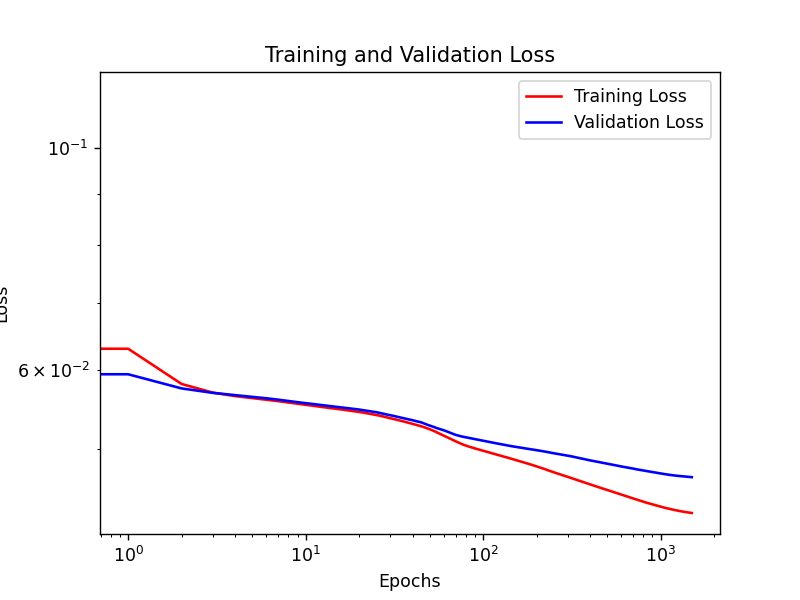

In [11]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels_cf)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data_cf)

print("Inferred value:", predict_cf[random_index])
#print("Actual value:", testing_labels_cf[random_index])
print(centerf[random_index])

NameError: name 'random' is not defined

In [13]:
print(centerf[1058])

0.0285496


In [ ]:
loss_cf = model.evaluate(testing_data_cf, batch_size=128)
print("test loss, test acc:", loss_cf)
print(loss_cf)
print(history_cf.history)

#mean square
loss_cf = history_cf.history['loss']
val_loss_cf = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss_cf)
sqrt_val_loss = np.sqrt(val_loss_cf)

In [ ]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#tf.config.list_physical_devices()